Goal: get AUPRC on fingerprints

In [68]:
# Imports

import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score
)

from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import jaccard

from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    accuracy_score,
    f1_score
)

from rdkit import Chem
from rdkit.Chem import AllChem

from matplotlib import pyplot as plt
import os

from typing import Tuple

from hyformer.utils.probing.knn import KNNProbe

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# miscelaneous functions

def _load_data(data_dir: str, split: str, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    """ Load data from directory.
    """
    data_filepath = os.path.join(data_dir, f'seed_{seed}', f'{split}.npz')
    data = np.load(data_filepath)
    X = data['sequence']
    y = data['target']
    return X, y


def evaluate_classification(y_true, y_pred_probs, threshold=None):
    
    if threshold is None:
        threshold = np.percentile(y_pred_probs, 95)
        print(f"Automatically selected threshold: {threshold:.3f}")
        
    y_pred_labels = (y_pred_probs >= threshold).astype(int)
    
    auprc = average_precision_score(y_true, y_pred_probs)
    auroc = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    
    # TPR and FPR at threshold
    tn = ((y_true == 0) & (y_pred_labels == 0)).sum()
    fp = ((y_true == 0) & (y_pred_labels == 1)).sum()
    fn = ((y_true == 1) & (y_pred_labels == 0)).sum()
    tp = ((y_true == 1) & (y_pred_labels == 1)).sum()
    
    tpr_at_threshold = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_at_threshold = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Precision@100
    sorted_indices = np.argsort(-y_pred_probs)
    top_100_indices = sorted_indices[:100]
    precision_at_100 = precision_score(y_true[top_100_indices], y_pred_labels[top_100_indices])
    
    # Enrichment Factor @1% and @5%
    n = len(y_true)
    top_1_percent = max(1, int(np.ceil(0.01 * n)))
    top_5_percent = max(1, int(np.ceil(0.05 * n)))
    
    ef1 = (y_true[sorted_indices[:top_1_percent]].sum() / top_1_percent) / (y_true.sum() / n)
    ef5 = (y_true[sorted_indices[:top_5_percent]].sum() / top_5_percent) / (y_true.sum() / n)
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred_labels)
    
    # F1 Score
    f1 = f1_score(y_true, y_pred_labels)
    
    return {
        'AUPRC': auprc,
        'AUROC': auroc,
        'Precision': precision,
        'Recall': recall,
        'Precision@100': precision_at_100,
        'EF@1%': ef1,
        'EF@5%': ef5,
        'Accuracy': accuracy,
        'FPR@threshold': fpr_at_threshold,
        'TPR@threshold': tpr_at_threshold,
        'F1': f1
    }
    
    
def display_results(results):
    for key, value in results.items():
        print(f"{key}: {value:.3f}")
    return None        


def plot_pr_curve(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    pr_auc = average_precision_score(y_true, y_pred_probs)
    
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()
    return None


def get_fingerprints(smiles_list, fp_type='morgan', radius=2, n_bits=2048):
    """
    Generate molecular fingerprints from a list of SMILES strings.
    
    Args:
        smiles_list: List of SMILES strings
        fp_type: Type of fingerprint ('morgan', 'rdkit', 'maccs', 'atom_pair', 'topological_torsion')
        radius: Radius for Morgan/ECFP fingerprints (default: 2)
        n_bits: Number of bits in the fingerprint (default: 2048)
        
    Returns:
        numpy array of fingerprints
    """
    from rdkit import Chem
    from rdkit.Chem import AllChem, MACCSkeys
    from rdkit.Chem import rdFingerprintGenerator
    import numpy as np
    
    # Convert SMILES to molecules
    mols = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            mols.append(mol)
        else:
            print(f"Warning: Could not parse SMILES: {smile}")
    
    # Generate fingerprints based on type
    fps = []
    
    if fp_type == 'morgan':
        # Morgan (ECFP) fingerprints using the new generator API
        morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
        fps = [morgan_gen.GetFingerprint(mol) for mol in mols]
    
    elif fp_type == 'rdkit':
        # RDKit path-based fingerprints
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=n_bits)
        fps = [rdkit_gen.GetFingerprint(mol) for mol in mols]
    
    elif fp_type == 'maccs':
        # MACCS keys (always 167 bits)
        fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
    
    elif fp_type == 'atom_pair':
        # Atom pair fingerprints
        atom_pair_gen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=n_bits)
        fps = [atom_pair_gen.GetFingerprint(mol) for mol in mols]
    
    elif fp_type == 'topological_torsion':
        # Topological torsion fingerprints
        torsion_gen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=n_bits)
        fps = [torsion_gen.GetFingerprint(mol) for mol in mols]
    
    else:
        raise ValueError(f"Unknown fingerprint type: {fp_type}")
    
    # Convert to numpy array
    fp_array = np.zeros((len(fps), n_bits if fp_type != 'maccs' else 167), dtype=np.int8)
    for i, fp in enumerate(fps):
        fp_array[i] = np.array(list(fp.ToBitString()), dtype=np.int8)
    
    return fp_array


def plot_class_histograms(y_pred_probs, y_true):
    """
    Plot separate histograms for positive and negative class predictions.
    
    Args:
        y_pred_probs: Predicted probabilities
        y_true: True labels (0 or 1)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(10, 6))
    
    # Separate predictions by class
    pos_probs = y_pred_probs[y_true == 1]
    neg_probs = y_pred_probs[y_true == 0]
    
    # Plot histograms
    plt.hist(neg_probs, bins=50, alpha=0.7, label='Negative Class (0)', color='red')
    plt.hist(pos_probs, bins=50, alpha=0.7, label='Positive Class (1)', color='green')
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Probabilities by Class')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    return None



In [ ]:
def calculate_tanimoto_similarities(test_fps, train_fps):
    """
    Calculate Tanimoto similarity between test and training fingerprints.
    
    Args:
        test_fps: Numpy array of test fingerprints (n_test x n_bits)
        train_fps: Numpy array of training fingerprints (n_train x n_bits)
        
    Returns:
        similarities: Numpy array of Tanimoto similarities (n_test x n_train)
                     Each row corresponds to a test molecule, each column to a train molecule
    """
    import numpy as np
    from scipy.sparse import csr_matrix
    
    # Convert to sparse matrices for efficiency if fingerprints are binary
    test_sparse = csr_matrix(test_fps)
    train_sparse = csr_matrix(train_fps)
    
    # Calculate dot product between test and train fingerprints
    # This gives us the intersection (bits that are 1 in both fingerprints)
    intersection = test_sparse.dot(train_sparse.T).toarray()
    
    # Calculate sum of bits in each fingerprint
    test_sum = np.array(test_sparse.sum(axis=1)).flatten()
    train_sum = np.array(train_sparse.sum(axis=1)).flatten()
    
    # Use broadcasting to calculate union for all pairs
    # union = a + b - intersection
    union = test_sum[:, np.newaxis] + train_sum[np.newaxis, :] - intersection
    
    # Tanimoto similarity = intersection / union
    # Handle division by zero (if both fingerprints are all zeros)
    similarities = np.zeros_like(intersection, dtype=float)
    nonzero_indices = union > 0
    similarities[nonzero_indices] = intersection[nonzero_indices] / union[nonzero_indices]
    
    return similarities


def get_nearest_neighbors(test_fps, train_fps, train_labels, k=5):
    """
    Find the k nearest neighbors (by Tanimoto similarity) for each test fingerprint.
    
    Args:
        test_fps: Numpy array of test fingerprints (n_test x n_bits)
        train_fps: Numpy array of training fingerprints (n_train x n_bits)
        train_labels: Numpy array of training labels
        k: Number of nearest neighbors to find
        
    Returns:
        neighbor_indices: Indices of nearest neighbors (n_test x k)
        neighbor_similarities: Similarities to nearest neighbors (n_test x k)
        neighbor_labels: Labels of nearest neighbors (n_test x k)
    """
    import numpy as np
    
    # Calculate all pairwise similarities
    similarities = calculate_tanimoto_similarities(test_fps, train_fps)
    
    # For each test molecule, find the k most similar training molecules
    n_test = test_fps.shape[0]
    neighbor_indices = np.zeros((n_test, k), dtype=int)
    neighbor_similarities = np.zeros((n_test, k), dtype=float)
    
    for i in range(n_test):
        # Get indices of top k most similar training molecules
        top_indices = np.argsort(similarities[i])[-k:][::-1]
        neighbor_indices[i] = top_indices
        neighbor_similarities[i] = similarities[i][top_indices]
    
    # Get labels of nearest neighbors
    neighbor_labels = train_labels[neighbor_indices]
    
    return neighbor_indices, neighbor_similarities, neighbor_labels


def visualize_similarity_distribution(test_fps, train_fps=None, bins=50):
    """
    Visualize the distribution of Tanimoto similarities.
    
    Args:
        test_fps: Numpy array of test fingerprints OR a precomputed similarity matrix
        train_fps: Numpy array of training fingerprints (optional if test_fps is a similarity matrix)
        bins: Number of bins for histogram (int)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Check if we were passed fingerprints or a similarity matrix
    if train_fps is not None:
        # We were passed fingerprints, calculate similarities
        similarities = calculate_tanimoto_similarities(test_fps, train_fps)
    else:
        # Assume test_fps is already a similarity matrix
        similarities = test_fps
    
    plt.figure(figsize=(10, 6))
    plt.hist(similarities.flatten(), bins=bins, alpha=0.7)
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Tanimoto Similarities')
    
    # Add vertical line for mean similarity
    mean_sim = np.mean(similarities)
    plt.axvline(x=mean_sim, color='r', linestyle='--', 
                label=f'Mean Similarity: {mean_sim:.3f}')
    
    # Add statistics
    plt.text(0.02, 0.95, 
             f"Min: {np.min(similarities):.3f}\n"
             f"Max: {np.max(similarities):.3f}\n"
             f"Mean: {mean_sim:.3f}\n"
             f"Median: {np.median(similarities):.3f}",
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
    
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    return None


In [69]:
# constants

DATA_DIR = '/lustre/groups/aih/antifibrotic.discovery/data/processed/30062025/processed/mds_split/combined'
RANDOM_STATE = 0



In [70]:
### Load  data

X_train, y_train = _load_data(DATA_DIR, split='train', seed=RANDOM_STATE)
X_val, y_val = _load_data(DATA_DIR, split='val', seed=RANDOM_STATE)
X_train, y_train = np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val])
X_test, y_test = _load_data(DATA_DIR, split='test', seed=RANDOM_STATE)


In [71]:
# featurize

X_train = get_fingerprints(X_train, fp_type='morgan')
X_test = get_fingerprints(X_test, fp_type='morgan')


Loaded data:
X_train.shape: (15127, 2048)
X_test.shape: (1070, 2048)
Class distribution:
y_train: 238
y_test: 11


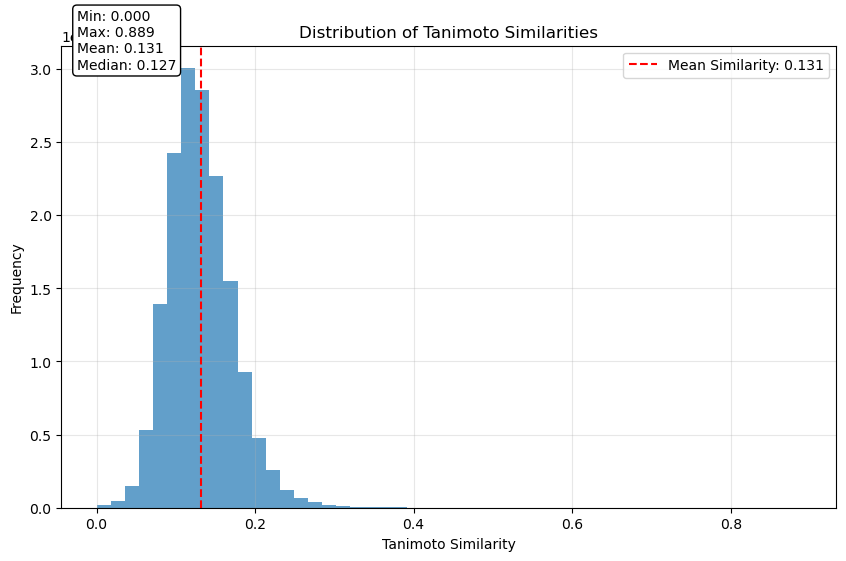

In [72]:
# verify distance of test molecules to train molecules

print("Loaded data:")
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

print(f"Class distribution:")
print(f"y_train: {len(y_train[y_train == 1])}")
print(f"y_test: {len(y_test[y_test == 1])}")


# verify similarity distribution
visualize_similarity_distribution(X_train, X_test)

KNN probe hyperparameter search: 100%|██████████| 18/18 [49:28<00:00, 164.90s/model]
/lustre/groups/aih/hyformer/env/hyformer_experiments/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Best hyperparameters: k=100, weights=soft-distance, cv_auprc=0.0979±0.0341
--- Results ---
Automatically selected threshold: 0.030
AUPRC: 0.088
AUROC: 0.734
Precision: 0.037
Recall: 0.182
Precision@100: 0.037
EF@1%: 17.686
EF@5%: 3.603
Accuracy: 0.943
FPR@threshold: 0.049
TPR@threshold: 0.182
F1: 0.062


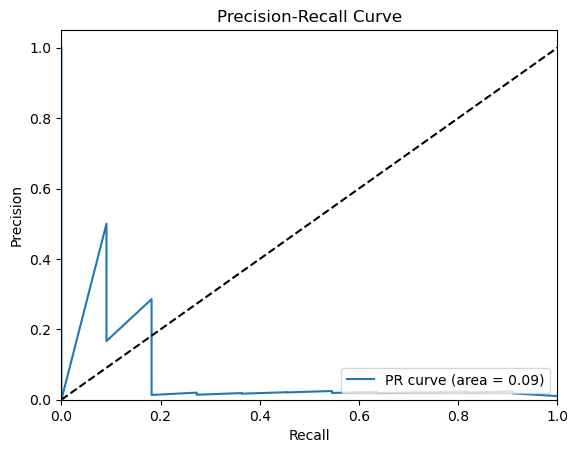

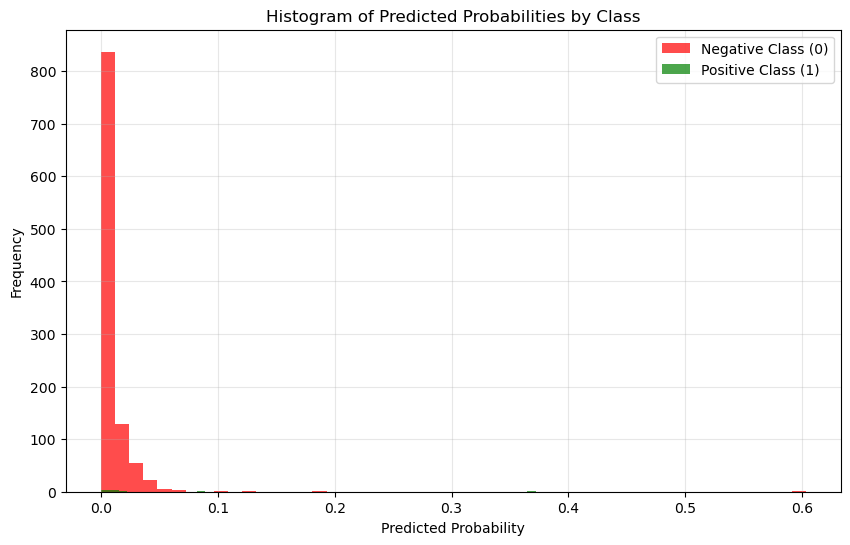

In [73]:


probe = KNNProbe(k=[1, 5, 10, 20, 50, 100], metric='jaccard', weights=['uniform', 'distance', 'soft-distance'])
probe.fit(X_train, y_train, selection_metric='auprc')
y_pred = probe.predict(X_test)

print("--- Results ---")
results = evaluate_classification(y_test, y_pred)
display_results(results)
plot_pr_curve(y_test, y_pred)
plot_class_histograms(y_pred, y_test)

In [ ]:
# Random Forest Classifier Implementation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np

class RFProbe:
    """Random Forest probe with 5-fold cross-validation for hyperparameter selection."""
    
    def __init__(self, param_grid: dict = None, cv_folds: int = 5, random_state: int = 42):
        """
        Initialize RF probe.
        
        Args:
            param_grid: Dictionary of hyperparameters to search over
            cv_folds: Number of cross-validation folds
            random_state: Random state for reproducibility
        """
        if param_grid is None:
            self.param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'class_weight': [None, 'balanced']
            }
        else:
            self.param_grid = param_grid
            
        self.cv_folds = cv_folds
        self.random_state = random_state
        self.best_estimator_ = None
        self.best_params_ = None
        self.cv_results_ = None
        
    def fit(self, X: np.ndarray, y: np.ndarray, selection_metric: str = 'auprc') -> 'RFProbe':
        """
        Fit RF probe with hyperparameter search using cross-validation.
        
        Args:
            X: Training features
            y: Training labels
            selection_metric: Metric to use for hyperparameter selection ('auprc' or 'auroc')
            
        Returns:
            self
        """
        # Set up cross-validation
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        
        # Set up scoring metric
        if selection_metric == 'auprc':
            scoring = 'average_precision'
        elif selection_metric == 'auroc':
            scoring = 'roc_auc'
        else:
            raise ValueError(f"Unknown selection metric: {selection_metric}")
        
        # Initialize base classifier
        rf = RandomForestClassifier(random_state=self.random_state)
        
        # Perform grid search
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=self.param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=1
        )
        
        # Fit the grid search
        grid_search.fit(X, y)
        
        # Store results
        self.best_estimator_ = grid_search.best_estimator_
        self.best_params_ = grid_search.best_params_
        self.cv_results_ = grid_search.cv_results_
        
        # Print best parameters and score
        best_score = grid_search.best_score_
        print(f"\nBest hyperparameters: {self.best_params_}")
        print(f"Best CV {selection_metric}: {best_score:.4f}")
        
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict probabilities for positive class.
        
        Args:
            X: Test features
            
        Returns:
            Predicted probabilities for positive class
        """
        if self.best_estimator_ is None:
            raise ValueError("Model must be fitted before making predictions")
            
        return self.best_estimator_.predict_proba(X)[:, 1]


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV auprc: 0.1619

--- Random Forest Results ---
Automatically selected threshold: 0.411
AUPRC: 0.134
AUROC: 0.722
Precision: 0.091
Recall: 0.062
Precision@100: 0.091
EF@1%: 0.000
EF@5%: 1.233
Accuracy: 0.885
FPR@threshold: 0.050
TPR@threshold: 0.062
F1: 0.074


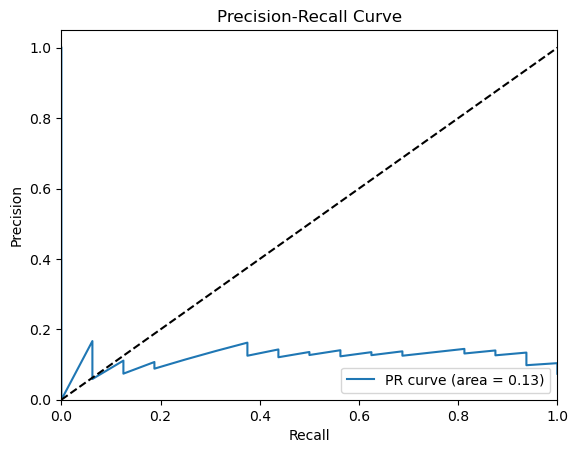

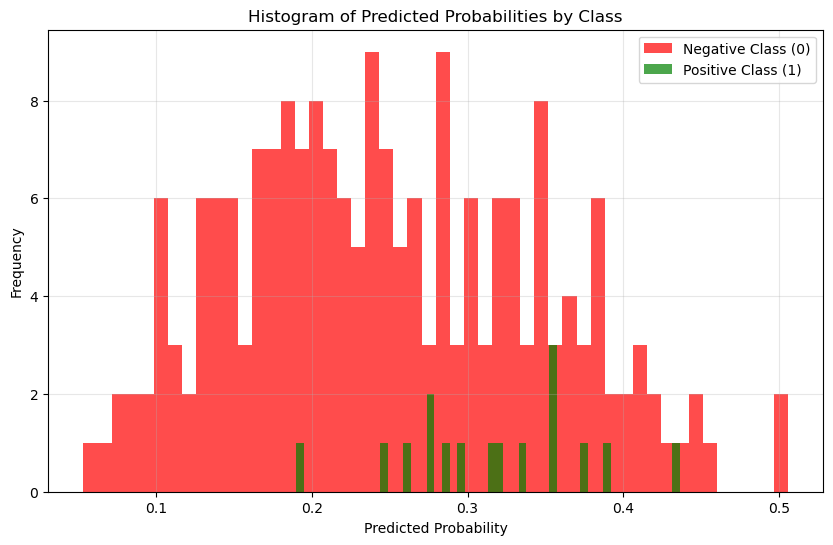

In [67]:
# Run Random Forest Classifier

# Initialize and fit RF probe using the same data (X, y) as KNN
rf_probe = RFProbe(cv_folds=5, random_state=RANDOM_STATE)
rf_probe.fit(X_train, y_train, selection_metric='auprc')

# Predict on test set
y_pred_rf = rf_probe.predict(X_test)

print("\n--- Random Forest Results ---")
results_rf = evaluate_classification(y_test, y_pred_rf)
display_results(results_rf)
plot_pr_curve(y_test, y_pred_rf)
plot_class_histograms(y_pred_rf, y_test)


In [74]:
# Load Hyformer

# Imports

import os

from hyformer.configs.dataset import DatasetConfig
from hyformer.configs.tokenizer import TokenizerConfig
from hyformer.configs.model import ModelConfig
from hyformer.configs.trainer import TrainerConfig

from hyformer.utils.datasets.auto import AutoDataset
from hyformer.utils.tokenizers.auto import AutoTokenizer
from hyformer.models.auto import AutoModel
from hyformer.trainers.trainer import Trainer

from hyformer.utils.runtime import set_seed

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'hyformer.utils.runtime'

In [ ]:
# Configs

DATA_DIR = '/lustre/groups/aih/antifibrotic.discovery/data/processed/30062025/processed/hi_split/fda'
OUTPUT_DIR = '/lustre/groups/aih/antifibrotic.discovery/results/finetune'

PATH_TO_DATASET_CONFIG   = '/lustre/groups/aih/antifibrotic.discovery/configs/datasets/hi/drd2/config.json'
PATH_TO_TOKENIZER_CONFIG = '/lustre/groups/aih/antifibrotic.discovery/configs/tokenizers/smiles_separate_task_token/config.json'
PATH_TO_MODEL_CONFIG = '/lustre/groups/aih/antifibrotic.discovery/configs/models/hyformer_v2_prediction/config.json'
PATH_TO_TRAINER_CONFIG = '/lustre/groups/aih/antifibrotic.discovery/configs/trainers/test/config.json'

In [ ]:
# Test Datsaset

dataset_config = DatasetConfig.from_config_filepath(PATH_TO_DATASET_CONFIG)
tokenizer_config = TokenizerConfig.from_config_filepath(PATH_TO_TOKENIZER_CONFIG)

train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')
val_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='val')
test_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='test')

tokenizer = AutoTokenizer.from_config(tokenizer_config)

In [ ]:
# Init Hyformer

model_config = ModelConfig.from_config_filepath(PATH_TO_MODEL_CONFIG)
model = AutoModel.from_config(model_config, downstream_task=dataset_config.prediction_task_type, num_prediction_tasks=dataset_config.num_prediction_tasks, hidden_dim=256)
# model.load_pretrained('ckpt.pt')

In [ ]:
MODEL_DIR = '/lustre/groups/aih/hyformer/results/distribution_learning/guacamol/hyformer/combined/hpo/lr_1e-4'



In [75]:
from hyformer import Hyformer

model = Hyformer.from_pretrained(MODEL_DIR)

ImportError: cannot import name 'Hyformer' from 'hyformer' (/ictstr01/home/aih/adam.izdebski/projects/hyformer/hyformer/__init__.py)